In [ ]:
conda install -c conda-forge imbalanced-learn

# 1. Importing necessary libraries and initital data exploration

In [56]:
import os
from glob import glob
import matplotlib.pyplot as plt
import random
import cv2
import pandas as pd
import numpy as np
import matplotlib.gridspec as gridspec
import seaborn as sns
import zlib
import itertools
import sklearn
import itertools
import scipy
import skimage
from skimage.transform import resize
import csv
from tqdm import tqdm
from sklearn import model_selection
from sklearn.model_selection import train_test_split, learning_curve,KFold,cross_val_score,StratifiedKFold
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix
import keras
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, Lambda, MaxPool2D, BatchNormalization
from keras.utils import np_utils
from keras.utils.np_utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras import models, layers, optimizers
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.utils import class_weight
from keras.optimizers import SGD, RMSprop, Adam, Adagrad, Adadelta, RMSprop
from keras.models import Sequential, model_from_json
from keras.layers import Activation,Dense, Dropout, Flatten, Conv2D, MaxPool2D,MaxPooling2D,AveragePooling2D, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from keras import backend as K
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.applications.inception_v3 import InceptionV3
from keras.applications.resnet50 import ResNet50
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
import tensorflow as tf

import warnings
warnings.filterwarnings("ignore")

In [3]:
from pyspark.sql import SparkSession
from pyspark.ml import feature
from pyspark.ml import classification
from pyspark.sql import functions as fn
from pyspark.ml import Pipeline
from pyspark.ml.image import ImageSchema

import pyspark.sql.functions as f

spark = SparkSession.builder.master("local").appName("Project_Group5").config("spark.master", "local[*]").getOrCreate()
sc = spark.sparkContext
%matplotlib inline

In [4]:
train_CNV = spark.read.format("image").load(r"C:\Users\Aneesh\Downloads\kermany2018\oct2017\OCT2017_\train\CNV")
train_DME = spark.read.format("image").load(r"C:\Users\Aneesh\Downloads\kermany2018\oct2017\OCT2017_\train\DME")
train_DRUSEN = spark.read.format("image").load(r"C:\Users\Aneesh\Downloads\kermany2018\oct2017\OCT2017_\train\DRUSEN")
train_NORMAL = spark.read.format("image").load(r"C:\Users\Aneesh\Downloads\kermany2018\oct2017\OCT2017_\train\NORMAL")

val_CNV = spark.read.format("image").load(r"C:\Users\Aneesh\Downloads\kermany2018\oct2017\OCT2017_\val\CNV")
val_DME = spark.read.format("image").load(r"C:\Users\Aneesh\Downloads\kermany2018\oct2017\OCT2017_\val\DME")
val_DRUSEN = spark.read.format("image").load(r"C:\Users\Aneesh\Downloads\kermany2018\oct2017\OCT2017_\val\DRUSEN")
val_NORMAL = spark.read.format("image").load(r"C:\Users\Aneesh\Downloads\kermany2018\oct2017\OCT2017_\val\NORMAL")

test_CNV = spark.read.format("image").load(r"C:\Users\Aneesh\Downloads\kermany2018\oct2017\OCT2017_\test\CNV")
test_DME = spark.read.format("image").load(r"C:\Users\Aneesh\Downloads\kermany2018\oct2017\OCT2017_\test\DME")
test_DRUSEN = spark.read.format("image").load(r"C:\Users\Aneesh\Downloads\kermany2018\oct2017\OCT2017_\test\DRUSEN")
test_NORMAL = spark.read.format("image").load(r"C:\Users\Aneesh\Downloads\kermany2018\oct2017\OCT2017_\test\NORMAL")

In [5]:
train_DME.printSchema()

root
 |-- image: struct (nullable = true)
 |    |-- origin: string (nullable = true)
 |    |-- height: integer (nullable = true)
 |    |-- width: integer (nullable = true)
 |    |-- nChannels: integer (nullable = true)
 |    |-- mode: integer (nullable = true)
 |    |-- data: binary (nullable = true)



In [6]:
#Total of 80,000+ training images in total which are skewed with respect to category
train_CNV.count(),train_DME.count(),train_DRUSEN.count(),train_NORMAL.count()

(37205, 11348, 8616, 26315)

In [7]:
val_CNV.count(),val_DME.count(),val_DRUSEN.count(),val_NORMAL.count()

(8, 8, 8, 8)

In [8]:
test_CNV.count(),test_DME.count(),test_DRUSEN.count(),test_NORMAL.count()

(242, 242, 242, 242)

# 2. Defining a few useful functions for data visualization

In [57]:
#Specifying the folders which contain entire train and test image data
train_dir = "/Users/xuanran/kermany2018/OCT2017 /train/"
test_dir =  "/Users/xuanran/kermany2018/OCT2017 /test/"


from tqdm import tqdm
# The data is already labelled in the form of 4 folders for each category. Further each image 
#contains  the name of the category it belongs to. 
imageSize=224

#The function get_data gives a numerical label to each of the 4 category folders. 

def get_data(folder):
           
    X = []
    y = []
    for folderName in os.listdir(folder):
        if not folderName.startswith('.'):
            if folderName in ['NORMAL']:
                label = 0
            elif folderName in ['CNV']:
                label = 1
            elif folderName in ['DME']:
                label = 2
            elif folderName in ['DRUSEN']:
                label = 3
            else:
                label = 4
            for image_filename in tqdm(os.listdir(folder + folderName)):
                img_file = cv2.imread(folder + folderName + '/' + image_filename)
                if img_file is not None:
                    img_file = skimage.transform.resize(img_file, (imageSize, imageSize, 3))
                    img_arr = np.asarray(img_file)
                    X.append(img_arr)
                    y.append(label)
    X = np.asarray(X)
    y = np.asarray(y)
    return X,y

X_train, y_train = get_data(train_dir)
X_test, y_test= get_data(test_dir)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_test, y_test, test_size=0.2) 

# Labels are encoded to hot vectors 
from keras.utils.np_utils import to_categorical
y_trainHot = to_categorical(y_train, num_classes = 4)
y_testHot = to_categorical(y_test, num_classes = 4)

100%|██████████| 242/242 [00:05<00:00, 41.32it/s]


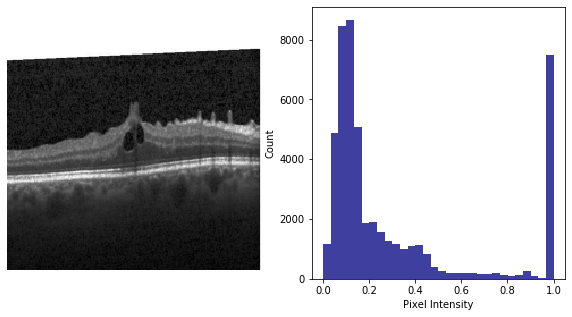

In [58]:
#The function plotHistogram plots histogram of RGB density of images for the 'CNV' category
def plotHistogram(a):
    
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.imshow(a)
    plt.axis('off')
    histo = plt.subplot(1,2,2)
    histo.set_ylabel('Count')
    histo.set_xlabel('Pixel Intensity')
    n_bins = 30
    plt.hist(a[:,:,0].flatten(), bins= n_bins, lw = 0, color='r', alpha=0.5);
    plt.hist(a[:,:,1].flatten(), bins= n_bins, lw = 0, color='g', alpha=0.5);
    plt.hist(a[:,:,2].flatten(), bins= n_bins, lw = 0, color='b', alpha=0.5);
plotHistogram(X_train[1])

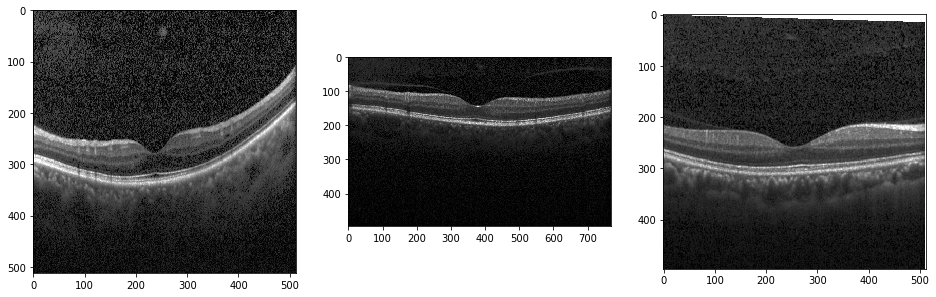

In [59]:
# Display a random sample of a glob of images from the 'NORMAL' category.
multipleImages = glob('/Users/xuanran/kermany2018/OCT2017 /train/NORMAL/**')
def plotThreeImages(images):
    r = random.sample(images, 3)
    plt.figure(figsize=(16,16))
    plt.subplot(131)
    plt.imshow(cv2.imread(r[0]))
    plt.subplot(132)
    plt.imshow(cv2.imread(r[1]))
    plt.subplot(133)
    plt.imshow(cv2.imread(r[2])); 
plotThreeImages(multipleImages)

Normal


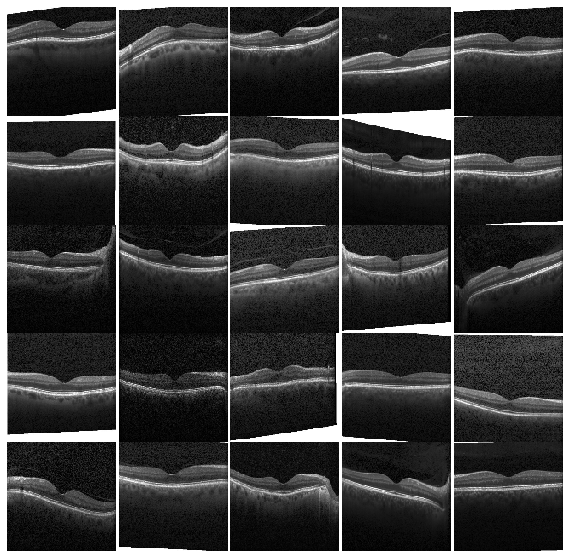

In [60]:
#Display a random set of 25 images from the 'Normal' category.
print("Normal")
multipleImages = glob('/Users/xuanran/kermany2018/OCT2017 /train/NORMAL/**')
i_ = 0
plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.subplots_adjust(wspace=0, hspace=0)
for l in multipleImages[:25]:
    im = cv2.imread(l)
    im = cv2.resize(im, (128, 128)) 
    plt.subplot(5, 5, i_+1) #.set_title(l)
    plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB)); plt.axis('off')
    i_ += 1

CNV


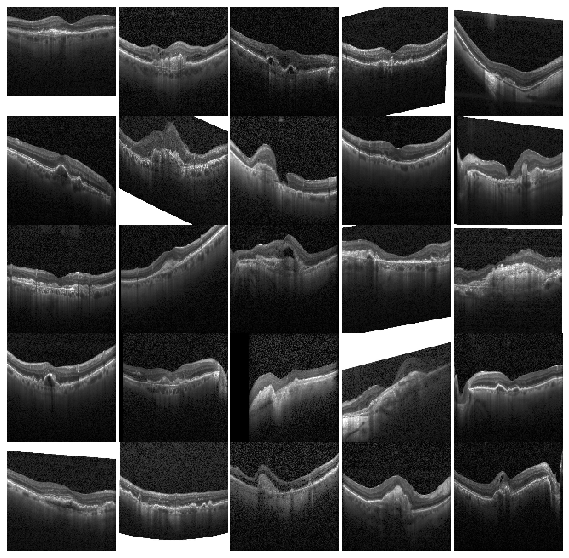

In [61]:
#Display a random set of 25 images from the 'CNV' category.
print("CNV")
multipleImages = glob('/Users/xuanran/kermany2018/OCT2017 /train/CNV/**')
i_ = 0
plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.subplots_adjust(wspace=0, hspace=0)
for l in multipleImages[:25]:
    im = cv2.imread(l)
    im = cv2.resize(im, (128, 128)) 
    plt.subplot(5, 5, i_+1) #.set_title(l)
    plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB)); plt.axis('off')
    i_ += 1

> Next, we define some helper functions so that we don't have to repeat computations for each model.

# 3. Helper functions

In [97]:
 
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# This callback saves model metrics after each epoch
class MetricsCheckpoint(Callback):
    
    def __init__(self, savepath):
        super(MetricsCheckpoint, self).__init__()
        self.savepath = savepath
        self.history = {}
    def on_epoch_end(self, epoch, logs=None):
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        np.save(self.savepath, self.history)

# Function to plot learning curve for model        
def plotKerasLearningCurve():
    plt.figure(figsize=(10,5))
    metrics = np.load('logs.npy', allow_pickle = True)[()]
    filt = ['acc'] # try to add 'loss' to see the loss learning curve
    for k in filter(lambda x : np.any([kk in x for kk in filt]), metrics.keys()):
        l = np.array(metrics[k])
        plt.plot(l, c= 'r' if 'val' not in k else 'b', label='val' if 'val' in k else 'train')
        x = np.argmin(l) if 'loss' in k else np.argmax(l)
        y = l[x]
        plt.scatter(x,y, lw=0, alpha=0.25, s=100, c='r' if 'val' not in k else 'b')
        plt.text(x, y, '{} = {:.4f}'.format(x,y), size='15', color= 'r' if 'val' not in k else 'b')   
    plt.legend(loc=4)
    plt.axis([0, None, None, None]);
    plt.grid()
    plt.xlabel('Number of epochs')
    plt.ylabel('Accuracy')

# Function to plot confusion_matrix for model
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (5,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Function to plot learning curve for model
def plot_learning_curve(history):
    plt.figure(figsize=(8,8))
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('./accuracy_curve.png')
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('./loss_curve.png')

# 4. Building Classification models

In [98]:
#We build 3 pre_trained models which use the concept of transfer learning: VGG-16, InceptionV3 and ResNet-50

map_characters1 = {0: 'Normal', 1: 'CNV', 2: 'DME', 3: 'DRUSEN'}
class_weight1 = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)
weight_path1 = 'imagenet'
weight_path2 = 'imagenet'
weight_path3 = 'imagenet'
pretrained_model_1 = VGG16(weights = weight_path1, include_top=False, input_shape=(imageSize, imageSize, 3))
pretrained_model_2 = InceptionV3(weights = weight_path2, include_top=False, input_shape=(imageSize, imageSize, 3))
pretrained_model_3 = ResNet50(weights = weight_path3, include_top=False, input_shape=(imageSize, imageSize, 3))
optimizer1 = keras.optimizers.Adam()
optimizer2 = keras.optimizers.RMSprop(lr=0.0001/2.0)

#Define a pretrained Network function that allows us to use similar code for training all models
def pretrainedNetwork(xtrain,ytrain,xtest,ytest,pretrainedmodel,pretrainedweights,classweight,numclasses,numepochs,optimizer,labels, batch_size = 32):
    base_model = pretrained_model_1 # Topless
    # Add top layer
    x = base_model.output
    x = Conv2D(256, kernel_size = (3,3), padding = 'valid')(x)
    x = Flatten()(x)
    x = Dropout(0.75)(x)
    predictions = Dense(numclasses, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    # Train top layer
    for layer in base_model.layers:
        layer.trainable = False
    model.compile(loss='categorical_crossentropy', 
                  optimizer=optimizer, 
                  metrics=['accuracy'])
    callbacks_list = [keras.callbacks.EarlyStopping(monitor='val_acc', patience=10, verbose=1)]
    model.summary()
    # Fit model
    history = model.fit(xtrain,ytrain, 
                        epochs=numepochs, 
                        batch_size = batch_size,
                        class_weight=classweight, 
                        validation_data=(xtest,ytest), 
                        verbose=1,
                        callbacks = callbacks_list+[MetricsCheckpoint('logs')])
    # Evaluate model
    score = model.evaluate(xtest,ytest, verbose=0)
    print('\nKeras CNN - accuracy:', score[1], '\n')
    y_pred = model.predict(xtest)
    print('\n', sklearn.metrics.classification_report(np.where(ytest > 0)[1], np.argmax(y_pred, axis=1), target_names=list(labels.values())), sep='') 
    Y_pred_classes = np.argmax(y_pred,axis = 1) 
    Y_true = np.argmax(ytest,axis = 1) 
    confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
    plotKerasLearningCurve()
    plt.show()
    plot_learning_curve(history)
    plt.show()
    plot_confusion_matrix(confusion_mtx, classes = list(labels.values()))
    plt.show()
    return model


{0: 'Normal', 1: 'CNV', 2: 'DME', 3: 'DRUSEN'}


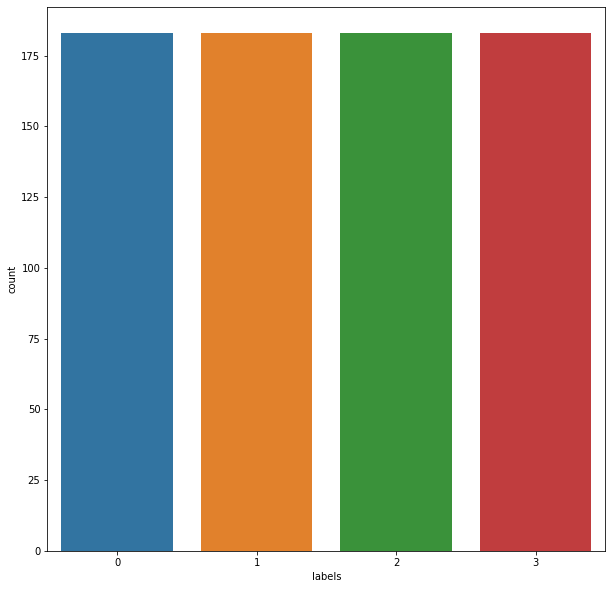

In [99]:
# As our training class sizes are skewed, we deal with imbalanced class sizes below using RandomUnderSampler
# Making Data 1-dimensional for compatability
X_trainShape = X_train.shape[1]*X_train.shape[2]*X_train.shape[3]
X_testShape = X_test.shape[1]*X_test.shape[2]*X_test.shape[3]
X_trainFlat = X_train.reshape(X_train.shape[0], X_trainShape)
X_testFlat = X_test.reshape(X_test.shape[0], X_testShape)
Y_train = y_train
Y_test = y_test

ros = RandomUnderSampler(sampling_strategy= 'auto')

X_trainRos, Y_trainRos = ros.fit_sample(X_trainFlat, Y_train)
X_testRos, Y_testRos = ros.fit_sample(X_testFlat, Y_test)
# Encoding labels to one-hot vectors
Y_trainRosHot = to_categorical(Y_trainRos, num_classes = 4)
Y_testRosHot = to_categorical(Y_testRos, num_classes = 4)
# Making Data 2-dimensional again
for i in range(len(X_trainRos)):
    height, width, channels = imageSize,imageSize,3
    X_trainRosReshaped = X_trainRos.reshape(len(X_trainRos),height,width,channels)
for i in range(len(X_testRos)):
    height, width, channels = imageSize,imageSize,3
    X_testRosReshaped = X_testRos.reshape(len(X_testRos),height,width,channels)
# Plotting Label Distribution for train
dfRos = pd.DataFrame()
dfRos["labels"]=Y_trainRos
labRos = dfRos['labels']
distRos = lab.value_counts()
sns.countplot(labRos)
print(dict_characters)

In [100]:
#Balancing class weights
class_weight1 = class_weight.compute_class_weight('balanced', np.unique(Y_train), Y_train)
print("Old Class Weights: ",class_weight1)
class_weight2 = class_weight.compute_class_weight('balanced', np.unique(Y_trainRos), Y_trainRos)
print("New Class Weights: ",class_weight2)

Old Class Weights:  [1.05737705 0.94390244 1.01308901 0.99230769]
New Class Weights:  [1. 1. 1. 1.]


In [101]:
# Shuffling data for further subsampling
from sklearn.utils import shuffle
X_trainRosReshaped, Y_trainRosHot = shuffle(X_trainRosReshaped, Y_trainRosHot, random_state=13)
X_testRosReshaped, Y_testRosHot = shuffle(X_testRosReshaped, Y_testRosHot, random_state=13)

# 5. Training models and evaluating them

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

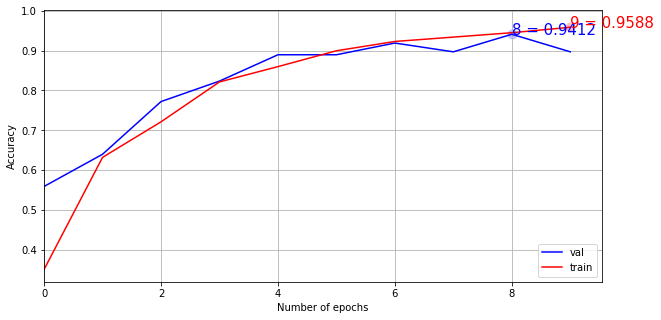

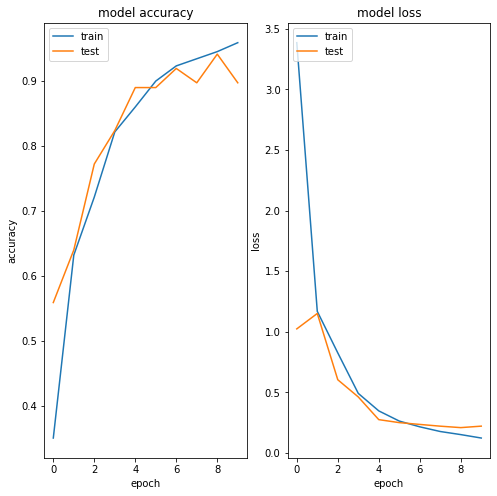

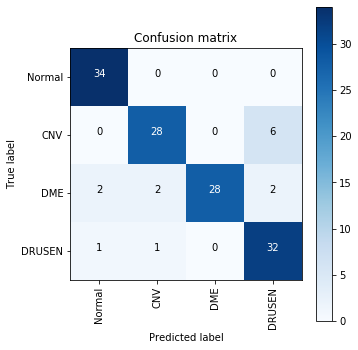

In [31]:
#This is model 1: VGG-16 (Please scroll down the output window for model evaluations and graphs)
pretrainedNetwork(X_trainRosReshaped[:10000], Y_trainRosHot[:10000], X_testRosReshaped[:2000], Y_testRosHot[:2000],
                  pretrained_model_1,
                  weight_path1,
                  class_weight2,
                  4,
                  10,
                  optimizer1,
                  map_characters1,
                 batch_size = 128)

In [ ]:
#Accuracy of 0.897 for VGG-16

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_37 (InputLayer)        (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

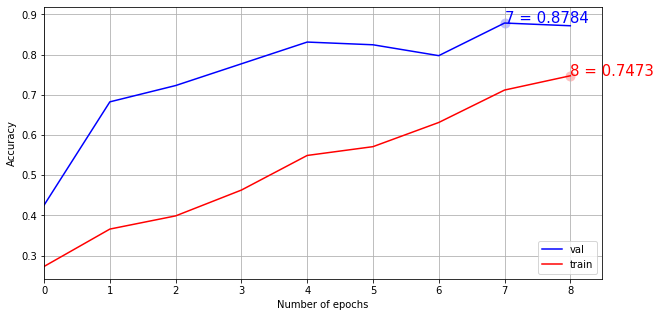

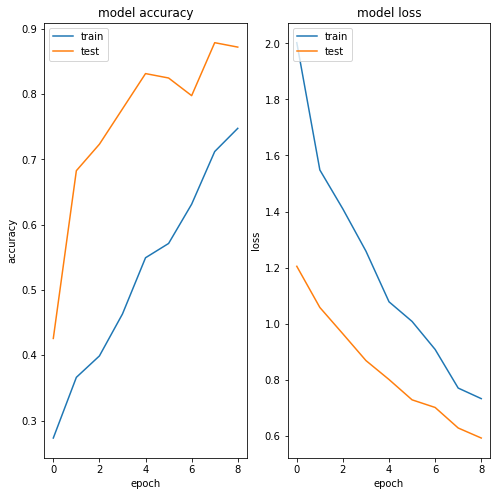

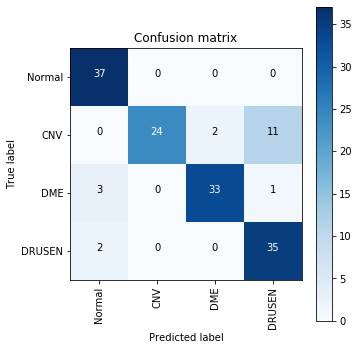

In [104]:
#This is model 2: ResNet50 (Please scroll down the output window for model evaluations and graphs)
pretrainedNetwork(X_trainRosReshaped[:10000], Y_trainRosHot[:10000], X_testRosReshaped[:2000], Y_testRosHot[:2000],
                  pretrained_model_3,
                  weight_path1,
                  class_weight2,
                  4,
                  9,
                  optimizer2,
                  map_characters1,
                 batch_size = 128)

In [ ]:
#Accuracy of 0.872 for ResNet-50

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

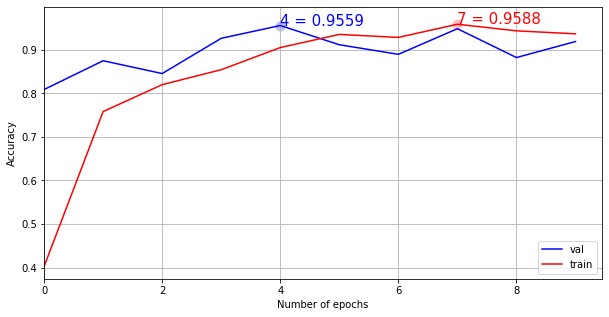

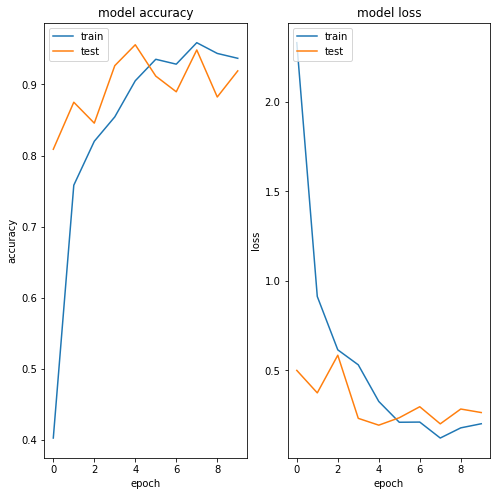

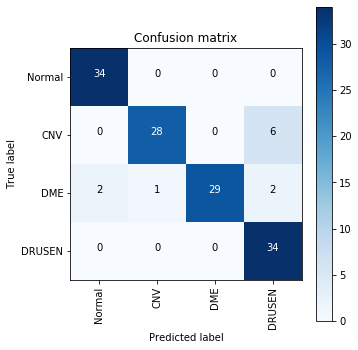

In [32]:
#This is model 3: InceptionV3 (Please scroll down the output window for model evaluations and graphs)
pretrainedNetwork(X_trainRosReshaped[:10000], 
                  Y_trainRosHot[:10000], 
                  X_testRosReshaped[:2000], 
                  Y_testRosHot[:2000],
                  pretrained_model_2,
                  weight_path2,
                  class_weight2,
                  4,
                  10,
                  optimizer1,
                  map_characters1,
                 batch_size = 64)

In [ ]:
#Accuracy of 0.92 for InceptionV3